In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,  LSTM,  Dropout, SimpleRNN, Input, GRU
from keras.models import Model
from keras import metrics
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from plot_keras_history import plot_history
%matplotlib inline

In [7]:
import os
path = os.getcwd()
print(path)

C:\home\program


In [3]:
tokyo = pd.read_csv('Stock2/東京(2014-1_2020-11).csv')
data =pd.read_csv("scraping/covid19_pref_20200421.csv")

tokyo['日付'] = pd.to_datetime(tokyo['日付'], format='%Y/%m/%d')
tokyo = tokyo.drop_duplicates(['日付', '終値'])

In [4]:
tokyo.set_index('日付')
dateTimeIndex = pd.DatetimeIndex(tokyo['日付'])
tokyo.index = dateTimeIndex
tokyo = tokyo.resample('D').interpolate()
tokyo.drop("日付", axis=1)

,終値
日付,
2014-01-06,686.0
2014-01-07,677.0
2014-01-08,692.0
2014-01-09,681.0
2014-01-10,686.0
...,...
2020-11-16,461.1
2020-11-17,479.4
2020-11-18,468.2


In [5]:
C_tokyo = pd.DataFrame(data['東京都'])
dateTimeIndex = pd.DatetimeIndex(data['date'])
C_tokyo.index = dateTimeIndex

In [6]:
tokyo = tokyo.astype({'終値': int})
C_tokyo = C_tokyo.astype({'東京都': int})

In [7]:
Tokyo = pd.DataFrame(tokyo['終値']['2020-01-15':'2020-11-01'])
N_Tokyo = pd.DataFrame(tokyo['終値']['2020-01-15':'2020-11-01'])

In [8]:
Tokyo['covid'] = C_tokyo['東京都']

In [9]:
scale = pd.DataFrame(np.nan_to_num(np.log(Tokyo['終値'].values + 1)))
scale.index = Tokyo.index.values

scale['second'] = np.nan_to_num(np.log(Tokyo['covid'].values + 1))
X_day_second = tokyo.index.values

In [10]:
X_orig = np.nan_to_num(np.log(Tokyo['終値'].values + 1))
X_day = Tokyo.index.values

X_orig_second = np.nan_to_num(np.log(Tokyo['covid'].values + 1))
X_day_second = Tokyo.index.values

In [11]:
half = round(len(X_orig)/2)

X_train = X_orig[:half-1]
X_test = X_orig[half:]
X_train_day = X_day[:half-1]
X_test_day = X_day[half:]

X_train_second = X_orig_second[:half-1]
X_test_second = X_orig_second[half:]
X_train_day_second = X_day_second[:half-1]
X_test_day_second = X_day_second[half:]

In [12]:
def show_graph(day, data, label, color="b", ylabel='stock price'):
    pylab.figure(figsize=(14, 8))
    pylab.subplot(211)
    pylab.xlabel('time')
    pylab.ylabel(ylabel)
    pylab.plot(day, data, color=color, label=label)
    pylab.legend(loc='upper right')
    pylab.show()

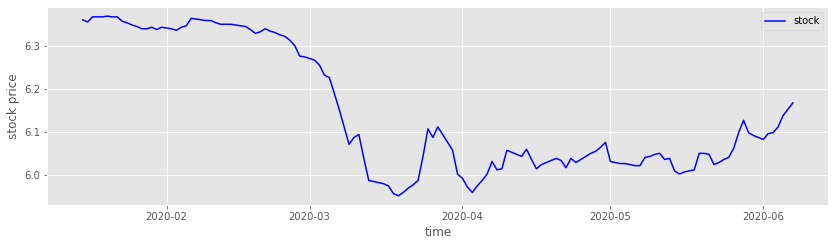

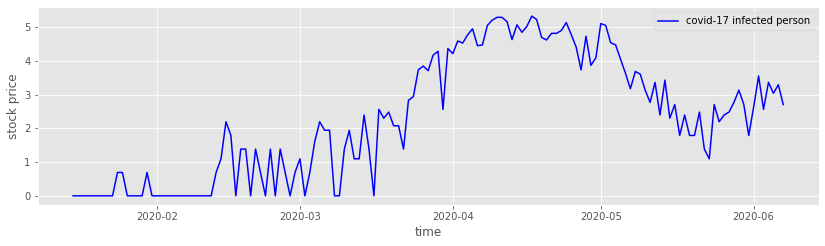

In [13]:
import pylab
plt.style.use('ggplot')
show_graph(X_train_day, X_train, 'stock')
show_graph(X_train_day_second, X_train_second, 'covid-17 infected person')

In [14]:
X_train_joint = np.vstack((X_train, X_train_second))
X_test_joint = np.vstack((X_test, X_test_second))

X_train_joint.shape

(2, 145)

In [15]:
def get_data(data, time_steps: int=3):
    dataX = []
    print(data.shape)
    dataX = np.zeros((data.shape[0], data.shape[1], time_steps))
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1] - time_steps - 1):
            dataX[i][j] = data[i, j:(j + time_steps)].T
    return np.array(dataX)

In [16]:
def transform_data(original_data: np.array, 
                   inverse_option: bool, 
                   scaler: object,
                   variable_number: int,
                  ):
    data_shape = original_data.shape
    print(original_data.shape)
    data = original_data.reshape(-1, variable_number)
    print(data.shape)
    if inverse_option is True:
        print('before max {}'.format(max(data[0])))
        print('Inverse')
        data = scaler.inverse_transform(data)
        print('after max {}'.format(max(data[0])))
    else:
        print('before max {}'.format(max(data[0])))
        print('Normalize')
        data = scaler.fit_transform(data)
        print('after max {}'.format(max(data[0])))
    data = data.reshape(data_shape)
    return data, scaler

In [17]:
def prepare_data(original_data, time_steps, variable_number):
    copy_data = original_data.copy()
    scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
    data, scaler = transform_data(original_data=copy_data, 
                              inverse_option=False, scaler=scaler, variable_number=variable_number)
    data = np.asarray(data)
    x = get_data(data, time_steps=time_steps)
    x = np.swapaxes(x, 0, 1)
    x = np.swapaxes(x, 1, 2)
    return x, scaler

In [18]:
time_steps = 3
variable_number = 2

x, scaler = prepare_data(X_train_joint, time_steps, variable_number)

(2, 145)
(145, 2)
before max 6.361302477572996
Normalize
after max 0.998918890325295
(2, 145)


In [19]:
input_dim = x.shape[-1]
timesteps = x.shape[1]

In [20]:
def create_model(input_dim,time_steps,latent_dim,model_option,batch_size=1,optimizer='adam'):
    with tf.name_scope('Model'):
        x = Input(shape=(time_steps, input_dim,))

        if model_option == 'lstm':
            with tf.name_scope('LSTM'):
                h = LSTM(latent_dim, stateful=False, return_sequences=True)(x)
        elif model_option == 'gru':
            with tf.name_scope('GRU'):
                h = GRU(latent_dim, stateful=False, return_sequences=True)(x)

        print('input_dim:', input_dim)
        with tf.name_scope('Dense'):
            out = Dense(input_dim)(h)

        model = Model(x, out)
        model.summary()

        with tf.name_scope('ModelCompile'):
            model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

    return model

In [21]:
from copy import copy 

def predict_model_show_graph(day, x, scaler, model, variable_number):
    prepare_value = x.copy()
    with timer('predict'):
        preds = model.predict(prepare_value)
    
    print('prepare_value: ', prepare_value.shape)
    print('preds: ', preds.shape)
       
    x_scale, scaler = transform_data(original_data=prepare_value, inverse_option=True, 
                                     scaler=scaler, variable_number=variable_number)

    predict_scale, scaler = transform_data(original_data=preds, inverse_option=True, 
                                           scaler=scaler, variable_number=variable_number)
    
    for i in range(prepare_value.shape[-1]):
        plt.figure(figsize=(14, 8))
        print('x_scale: ', prepare_value.shape)
        plt.plot(prepare_value[:, 0, i], color='r', label='data')
        plt.plot(preds[:, 0, i], color='b', label='predict')
        plt.legend()
        plt.show()
    
    print('model evaluate mse:', model.evaluate(preds, prepare_value))
    return preds, prepare_value
    # return predict_scale, x_scale

In [22]:
predict_list = []
var_list = []

print(x.shape)
model = create_model(input_dim,time_steps=time_steps,latent_dim=120,model_option='lstm')

(145, 3, 2)
input_dim: 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 2)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 120)            59040     
_________________________________________________________________
dense_1 (Dense)              (None, 3, 2)              242       
Total params: 59,282
Trainable params: 59,282
Non-trainable params: 0
_________________________________________________________________


In [23]:
import time
from contextlib import contextmanager

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.10f}s".format(title, time.time() - t0))

Epoch 1/300
145/145 [==============================] - 0s 3ms/step - loss: 0.4898 - mse: 0.4898
Epoch 2/300
145/145 [==============================] - 0s 173us/step - loss: 0.3931 - mse: 0.3931
Epoch 3/300
145/145 [==============================] - 0s 145us/step - loss: 0.3065 - mse: 0.3065
Epoch 4/300
145/145 [==============================] - 0s 159us/step - loss: 0.2301 - mse: 0.2301
Epoch 5/300
145/145 [==============================] - 0s 145us/step - loss: 0.1731 - mse: 0.1731
Epoch 6/300
145/145 [==============================] - 0s 159us/step - loss: 0.1461 - mse: 0.1461
Epoch 7/300
145/145 [==============================] - 0s 152us/step - loss: 0.1411 - mse: 0.1411
Epoch 8/300
145/145 [==============================] - 0s 152us/step - loss: 0.1306 - mse: 0.1306
Epoch 9/300
145/145 [==============================] - 0s 159us/step - loss: 0.1160 - mse: 0.1160
Epoch 10/300
145/145 [==============================] - 0s 159us/step - loss: 0.1057 - mse: 0.1057
Epoch 11/300
145/145 

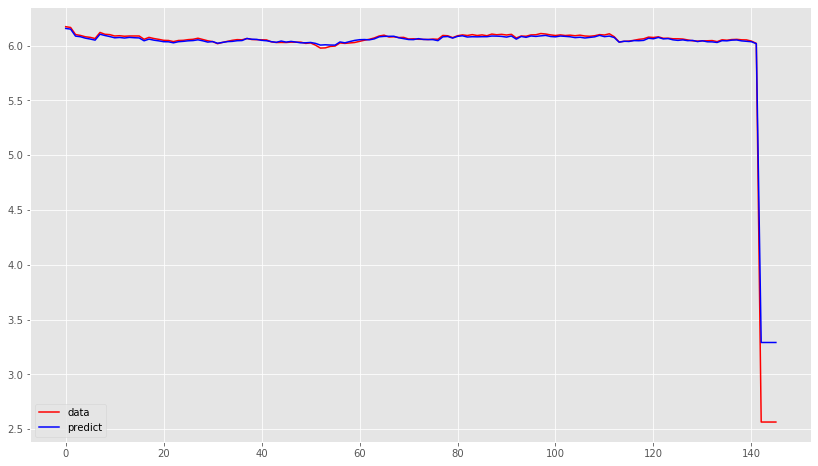

x_scale:  (146, 3, 2)


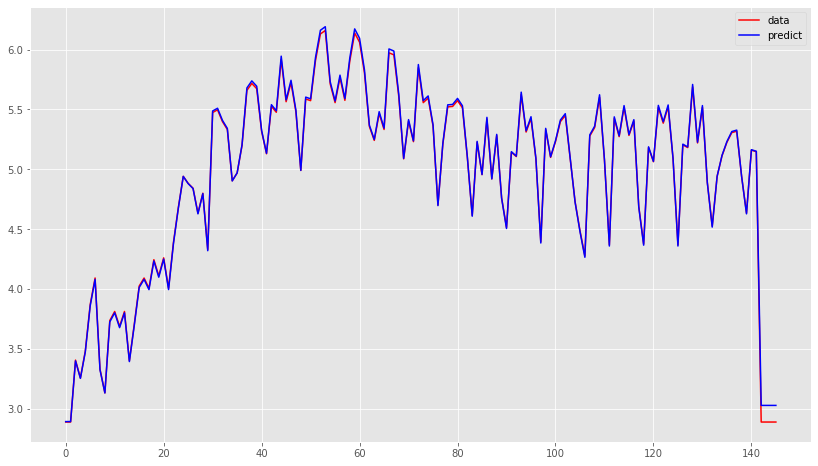

146/146 [==============================] - 0s 425us/step
model evaluate mse: [0.8944249773678714, 0.8944249749183655]


In [24]:
from pathlib import Path
from keras.callbacks import TensorBoard

log_dir = 'simple_multi_model'
p = Path(log_dir)
p.mkdir(parents=True, exist_ok=True)
tensorboard = TensorBoard(log_dir=log_dir,write_graph=True,embeddings_freq=0,)

with timer('train model simple'):
    model.fit(x, x, epochs=300, callbacks=[tensorboard])
window = time_steps
x_test, scaler = prepare_data(X_test_joint, time_steps, variable_number)
predict_test, x_scale_test = predict_model_show_graph(X_test_day[window + 1:], x_test, scaler, model,variable_number)

In [25]:
rmse_list = []
for i in range(predict_test.shape[-1]):
    print
    rmse = np.sqrt(np.average(np.subtract(x_scale_test[:, :, i], predict_test[:, :, i]) ** 2))
    print('rmse:', rmse)
    rmse_list.append(rmse)

print(np.average(rmse_list))

rmse: 0.0707528722392041
rmse: 0.01881287324408595
0.044782872741645025


In [26]:
lstm_test = np.exp(x_scale_test[:, 0, 0])
lstm_pred = np.exp(predict_test[:, 0, 0])

In [27]:
C_lstm_predict = pd.DataFrame(lstm_pred)
C_lstm_predict.index = X_day_second[half:]

C_lstm_test = pd.DataFrame(lstm_test)
C_lstm_test.index = X_day[half:]

# GRU

In [28]:
model = create_model(input_dim,time_steps=time_steps,latent_dim=120,model_option='gru')

input_dim: 2
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3, 2)              0         
_________________________________________________________________
gru_1 (GRU)                  (None, 3, 120)            44280     
_________________________________________________________________
dense_2 (Dense)              (None, 3, 2)              242       
Total params: 44,522
Trainable params: 44,522
Non-trainable params: 0
_________________________________________________________________


Epoch 1/300
145/145 [==============================] - 0s 3ms/step - loss: 0.3957 - mse: 0.3957
Epoch 2/300
145/145 [==============================] - 0s 193us/step - loss: 0.2455 - mse: 0.2455
Epoch 3/300
145/145 [==============================] - 0s 173us/step - loss: 0.1461 - mse: 0.1461
Epoch 4/300
145/145 [==============================] - 0s 180us/step - loss: 0.1036 - mse: 0.1036
Epoch 5/300
145/145 [==============================] - 0s 179us/step - loss: 0.0961 - mse: 0.0961
Epoch 6/300
145/145 [==============================] - 0s 172us/step - loss: 0.0850 - mse: 0.0850
Epoch 7/300
145/145 [==============================] - 0s 166us/step - loss: 0.0690 - mse: 0.0690
Epoch 8/300
145/145 [==============================] - 0s 180us/step - loss: 0.0575 - mse: 0.0575
Epoch 9/300
145/145 [==============================] - 0s 173us/step - loss: 0.0500 - mse: 0.0500
Epoch 10/300
145/145 [==============================] - 0s 179us/step - loss: 0.0436 - mse: 0.0436
Epoch 11/300
145/145 

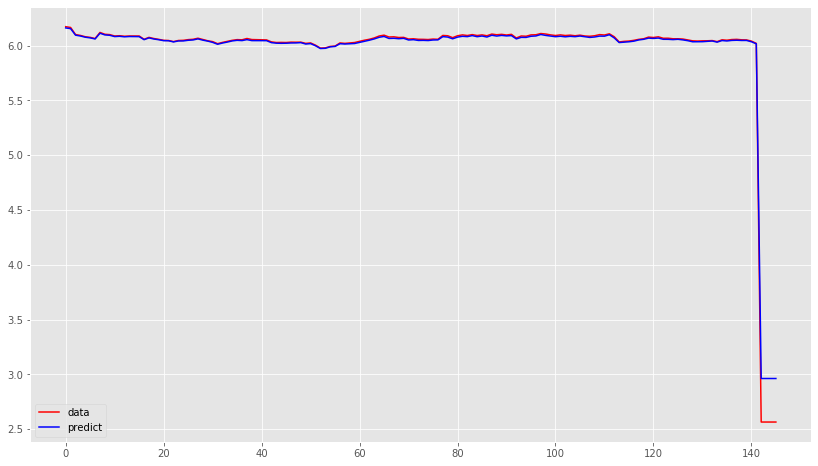

x_scale:  (146, 3, 2)


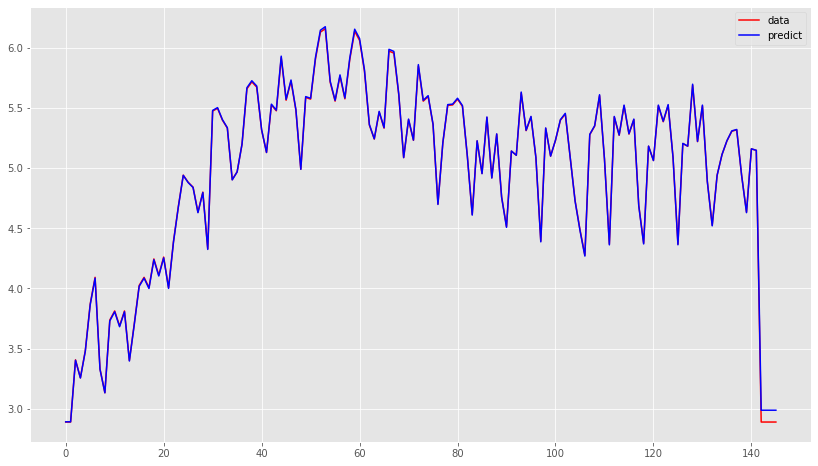

146/146 [==============================] - 0s 428us/step
model evaluate mse: [0.8581283239469136, 0.8581283092498779]


In [29]:
log_dir = 'simple_multi_model'
p = Path(log_dir)
p.mkdir(parents=True, exist_ok=True)
tensorboard = TensorBoard(log_dir=log_dir,write_graph=True,embeddings_freq=0,)

with timer('train model simple'):
    model.fit(x, x, epochs=300, callbacks=[tensorboard])
window = time_steps
x_test, scaler = prepare_data(X_test_joint, time_steps, variable_number)
predict_test, x_scale_test = predict_model_show_graph(X_test_day[window + 1:], x_test, scaler, model,variable_number)

In [30]:
rmse_list = []
for i in range(predict_test.shape[-1]):
    print
    rmse = np.sqrt(np.average(np.subtract(x_scale_test[:, :, i], predict_test[:, :, i]) ** 2))
    print('rmse:', rmse)
    rmse_list.append(rmse)

print(np.average(rmse_list))

rmse: 0.03932209514264201
rmse: 0.010870767068789226
0.02509643110571562


In [31]:
gru_test = np.exp(x_scale_test[:, 0, 0])
gru_pred = np.exp(predict_test[:, 0, 0])

In [32]:
C_gru_predict = pd.DataFrame(gru_pred)
C_gru_predict.index = X_day_second[half:]

C_gru_test = pd.DataFrame(gru_test)
C_gru_test.index = X_day[half:]

# simple

In [33]:
L = len(N_Tokyo)
Y = N_Tokyo  # 終値の列のみ抽出する。
Y = np.array(Y)  # numpy配列に変換する。
Y = Y.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）

In [34]:
X1 = Y[0:L-3, :]  # 予測対象日の3日前のデータ
X2 = Y[1:L-2, :]  # 予測対象日の2日前のデータ
X3 = Y[2:L-1, :]  # 予測対象日の前日データ
Y = Y[3:L, :]  # 予測対象日のデータ
X = np.concatenate([X1, X2, X3], axis=1)  # numpy配列を結合する。

In [35]:
scaler = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler.fit(X)  # スケーリングに使用する最小／最大値を計算する。
X = scaler.transform(X)  # Xをを0～1の範囲にスケーリングする。

In [36]:
scaler1 = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler1.fit(Y)  # スケーリングに使用する最小／最大値を計算する。
Y = scaler1.transform(Y)  # Yをを0～1の範囲にスケーリングする。

In [37]:
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # 3次元配列に変換する。

In [38]:
# train, testデータを定義
X_train = X[:half-1, :, :]
X_test = X[half:, :, :]
Y_train = Y[:half-1, :]
YN_test = Y[half:, :]

# lstm

In [39]:
model = Sequential()
model.add(LSTM(10, activation = 'tanh',batch_input_shape=(None, 1, timesteps), recurrent_activation= 'hard_sigmoid'))
model.add(Dense(10))
model.add(Dense(1))

Epoch 1/300
 - 0s - loss: 0.2260 - mean_absolute_error: 0.3674
Epoch 2/300
 - 0s - loss: 0.1963 - mean_absolute_error: 0.3334
Epoch 3/300
 - 0s - loss: 0.1679 - mean_absolute_error: 0.3012
Epoch 4/300
 - 0s - loss: 0.1422 - mean_absolute_error: 0.2709
Epoch 5/300
 - 0s - loss: 0.1194 - mean_absolute_error: 0.2434
Epoch 6/300
 - 0s - loss: 0.0995 - mean_absolute_error: 0.2205
Epoch 7/300
 - 0s - loss: 0.0824 - mean_absolute_error: 0.2032
Epoch 8/300
 - 0s - loss: 0.0682 - mean_absolute_error: 0.1912
Epoch 9/300
 - 0s - loss: 0.0557 - mean_absolute_error: 0.1824
Epoch 10/300
 - 0s - loss: 0.0472 - mean_absolute_error: 0.1773
Epoch 11/300
 - 0s - loss: 0.0402 - mean_absolute_error: 0.1718
Epoch 12/300
 - 0s - loss: 0.0356 - mean_absolute_error: 0.1681
Epoch 13/300
 - 0s - loss: 0.0324 - mean_absolute_error: 0.1642
Epoch 14/300
 - 0s - loss: 0.0302 - mean_absolute_error: 0.1601
Epoch 15/300
 - 0s - loss: 0.0279 - mean_absolute_error: 0.1550
Epoch 16/300
 - 0s - loss: 0.0264 - mean_absolute

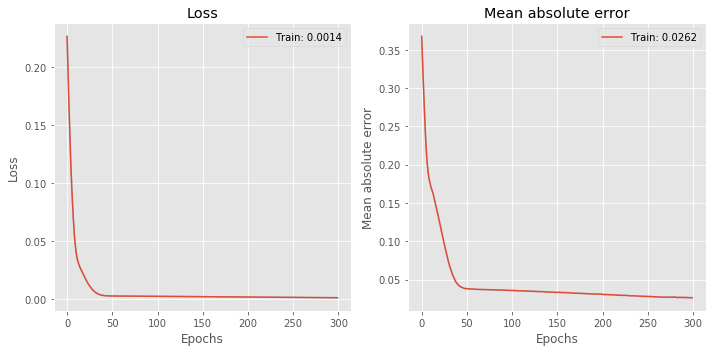

In [40]:
model.compile(loss= 'mean_squared_error', optimizer = 'adam', metrics=[metrics.mae])
history = model.fit(X_train, Y_train, epochs=300, verbose=2).history
plot_history(history)
lstm_predict = model.predict(X_test)

# GRU

In [41]:
model = Sequential()
model.add(GRU(10, activation='tanh', batch_input_shape=(None, 1, timesteps), recurrent_activation= 'hard_sigmoid'))
model.add(Dense(10))
model.add(Dense(1))

Epoch 1/300
 - 0s - loss: 0.3513 - mean_absolute_error: 0.4602
Epoch 2/300
 - 0s - loss: 0.2825 - mean_absolute_error: 0.4010
Epoch 3/300
 - 0s - loss: 0.2254 - mean_absolute_error: 0.3461
Epoch 4/300
 - 0s - loss: 0.1753 - mean_absolute_error: 0.2966
Epoch 5/300
 - 0s - loss: 0.1365 - mean_absolute_error: 0.2569
Epoch 6/300
 - 0s - loss: 0.1039 - mean_absolute_error: 0.2254
Epoch 7/300
 - 0s - loss: 0.0783 - mean_absolute_error: 0.2067
Epoch 8/300
 - 0s - loss: 0.0626 - mean_absolute_error: 0.1981
Epoch 9/300
 - 0s - loss: 0.0496 - mean_absolute_error: 0.1875
Epoch 10/300
 - 0s - loss: 0.0423 - mean_absolute_error: 0.1819
Epoch 11/300
 - 0s - loss: 0.0367 - mean_absolute_error: 0.1749
Epoch 12/300
 - 0s - loss: 0.0336 - mean_absolute_error: 0.1690
Epoch 13/300
 - 0s - loss: 0.0315 - mean_absolute_error: 0.1643
Epoch 14/300
 - 0s - loss: 0.0292 - mean_absolute_error: 0.1579
Epoch 15/300
 - 0s - loss: 0.0270 - mean_absolute_error: 0.1515
Epoch 16/300
 - 0s - loss: 0.0249 - mean_absolute

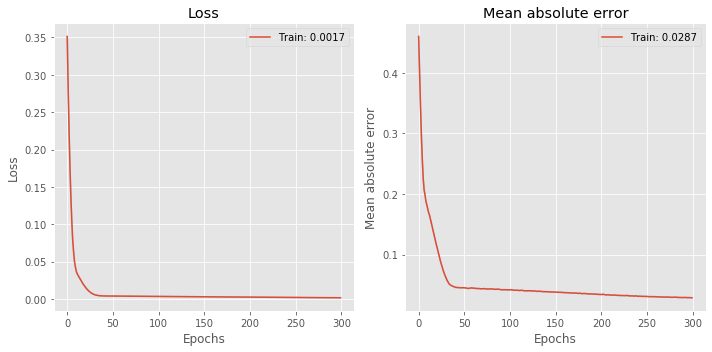

In [42]:
model.compile(loss= 'mean_squared_error', optimizer = 'adam', metrics=[metrics.mae])
history = model.fit(X_train, Y_train, epochs=300, verbose=2).history
plot_history(history)
gru_predict = model.predict(X_test)

In [43]:
YN_test = scaler1.inverse_transform(YN_test)
YN_test = pd.DataFrame(YN_test)
YN_test.index = pd.to_datetime(N_Tokyo.index[half+3:])

In [44]:
lstm_predict = scaler1.inverse_transform(lstm_predict)
lstm_predict = pd.DataFrame(lstm_predict)
lstm_predict.index = pd.to_datetime(N_Tokyo.index[half+3:])

In [45]:
gru_predict = scaler1.inverse_transform(gru_predict)
gru_predict = pd.DataFrame(gru_predict)
gru_predict.index = pd.to_datetime(N_Tokyo.index[half+3:])

In [46]:
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler1.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)
Y_train.index = pd.to_datetime(N_Tokyo.index[3:half+2])

# plot

In [47]:
C_lstm_test = C_lstm_test.drop(C_lstm_test.index[[len(C_lstm_test)-1,len(C_lstm_test)-2, len(C_lstm_test)-3, len(C_lstm_test)-4]])
C_lstm_predict = C_lstm_predict.drop(C_lstm_predict.index[[len(C_lstm_predict)-1,len(C_lstm_predict)-2, len(C_lstm_predict)-3, len(C_lstm_predict)-4]])

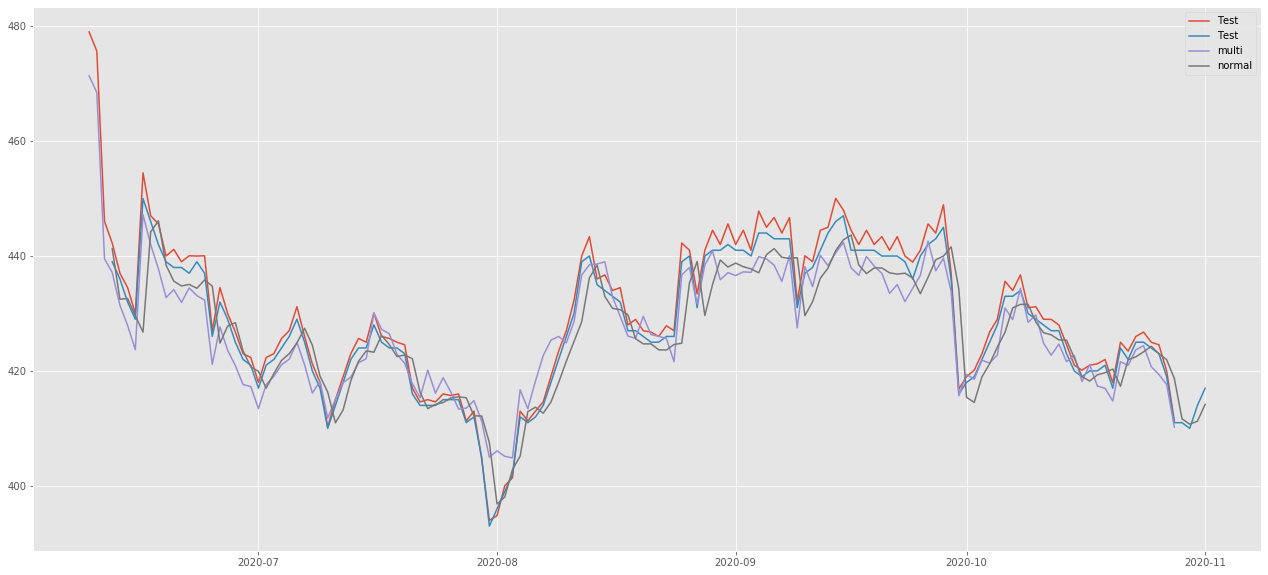

In [48]:
plt.figure(figsize=(22,10))
plt.plot(C_lstm_test, label = 'Test')
plt.plot(YN_test, label = 'Test')
plt.plot(C_lstm_predict, label = 'multi')
plt.plot(lstm_predict, label = 'normal')
plt.legend(loc='best')
#plt.savefig('画像/11-16/epoch300.png')

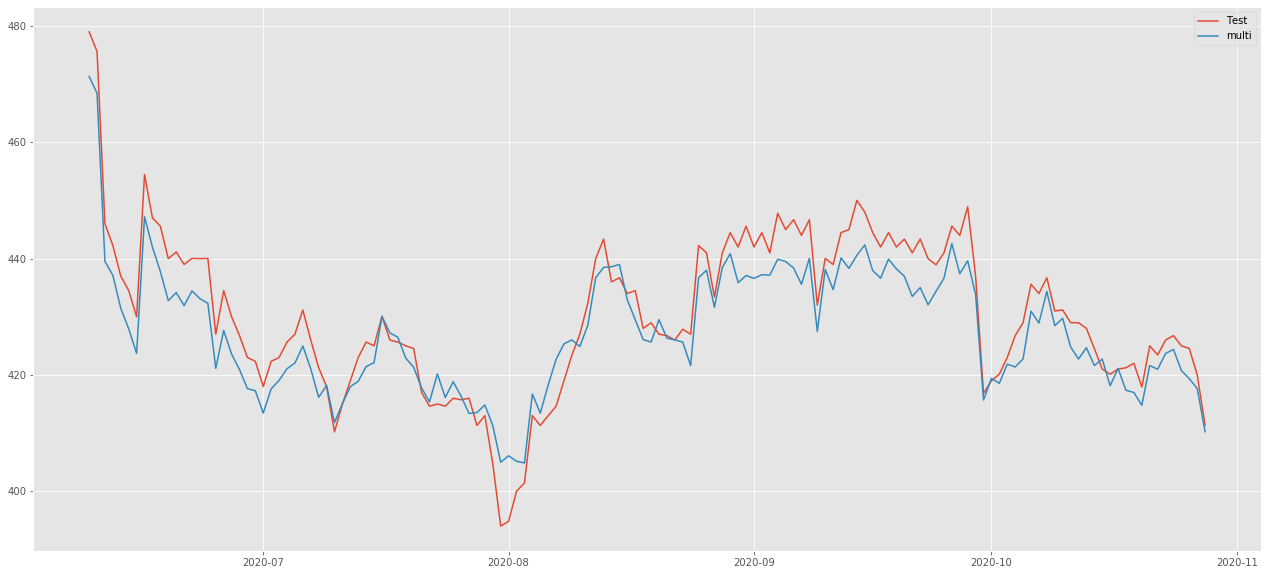

In [49]:
plt.figure(figsize=(22,10))
plt.plot(C_lstm_test, label = 'Test')
plt.plot(C_lstm_predict, label = 'multi')
plt.legend(loc='best')
#plt.savefig('画像/11-16/lstm-multi-epoch300.png')

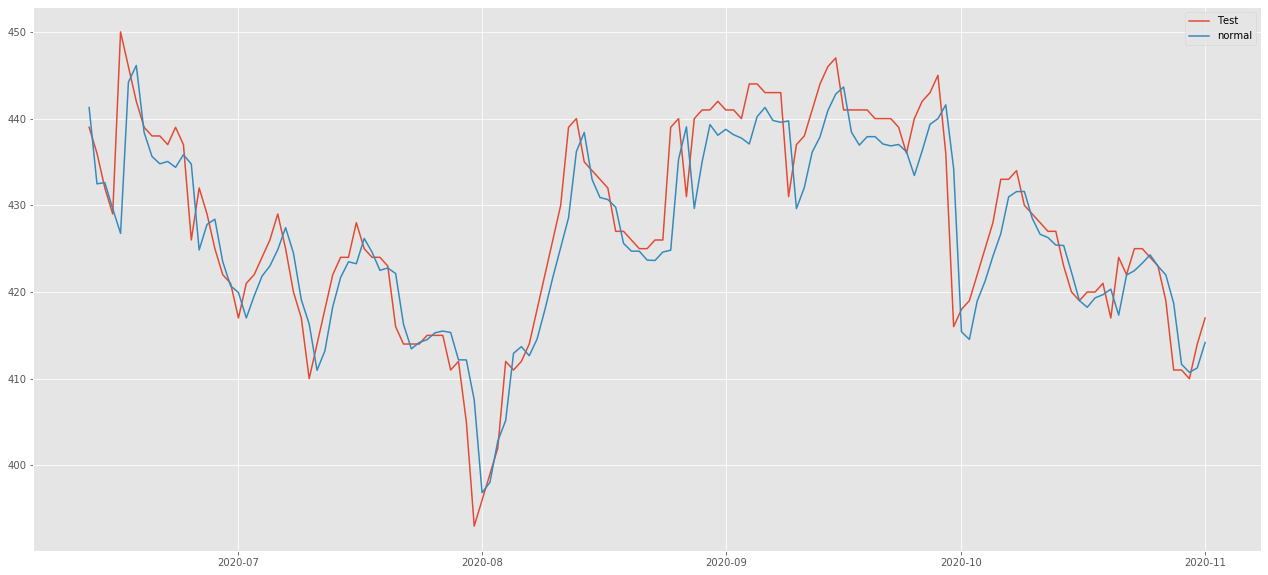

In [50]:
plt.figure(figsize=(22,10))
plt.plot(YN_test, label = 'Test')
plt.plot(lstm_predict, label = 'normal')
plt.legend(loc='best')
#plt.savefig('画像/11-16/lstm-epoch300.png')

In [51]:
C_gru_test = C_gru_test.drop(C_gru_test.index[[len(C_gru_test)-1,len(C_gru_test)-2, len(C_gru_test)-3, len(C_gru_test)-4]])
C_gru_predict = C_gru_predict.drop(C_gru_predict.index[[len(C_gru_predict)-1,len(C_gru_predict)-2, len(C_gru_predict)-3, len(C_gru_predict)-4]])

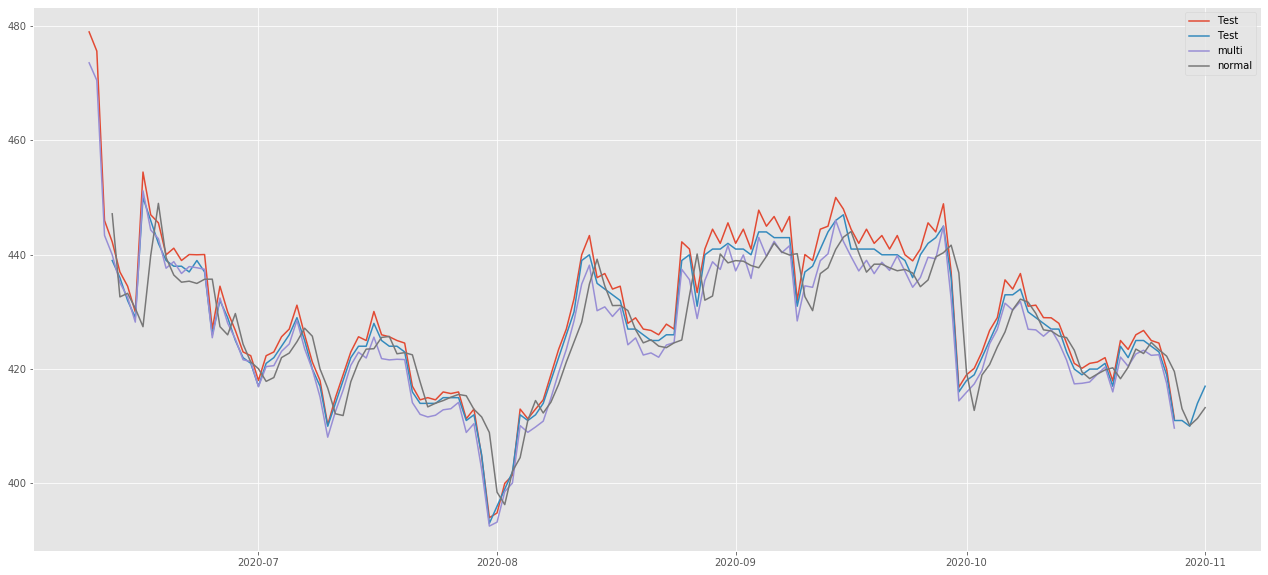

In [52]:
plt.figure(figsize=(22,10))
plt.plot(C_gru_test, label = 'Test')
plt.plot(YN_test, label = 'Test')
plt.plot(C_gru_predict, label = 'multi')
plt.plot(gru_predict, label = 'normal')
plt.legend(loc='best')
#plt.savefig('画像/11-16/epoch300-g.png')

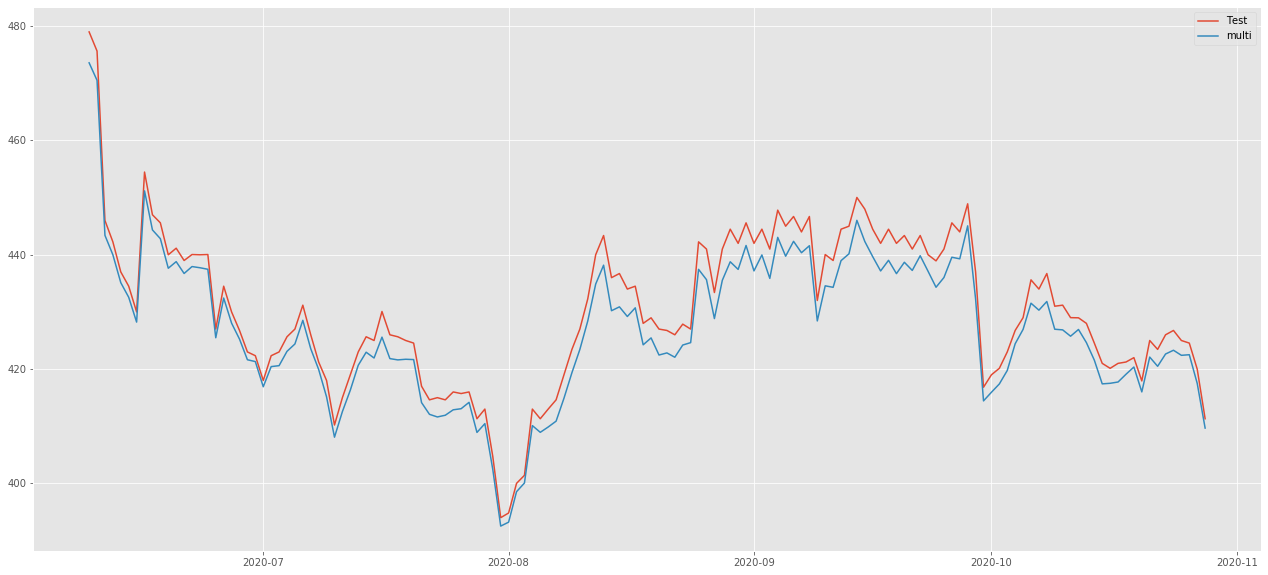

In [53]:
plt.figure(figsize=(22,10))
plt.plot(C_gru_test, label = 'Test')
plt.plot(C_gru_predict, label = 'multi')
plt.legend(loc='best')
#plt.savefig('画像/11-16/gru-multi-epoch300.png')

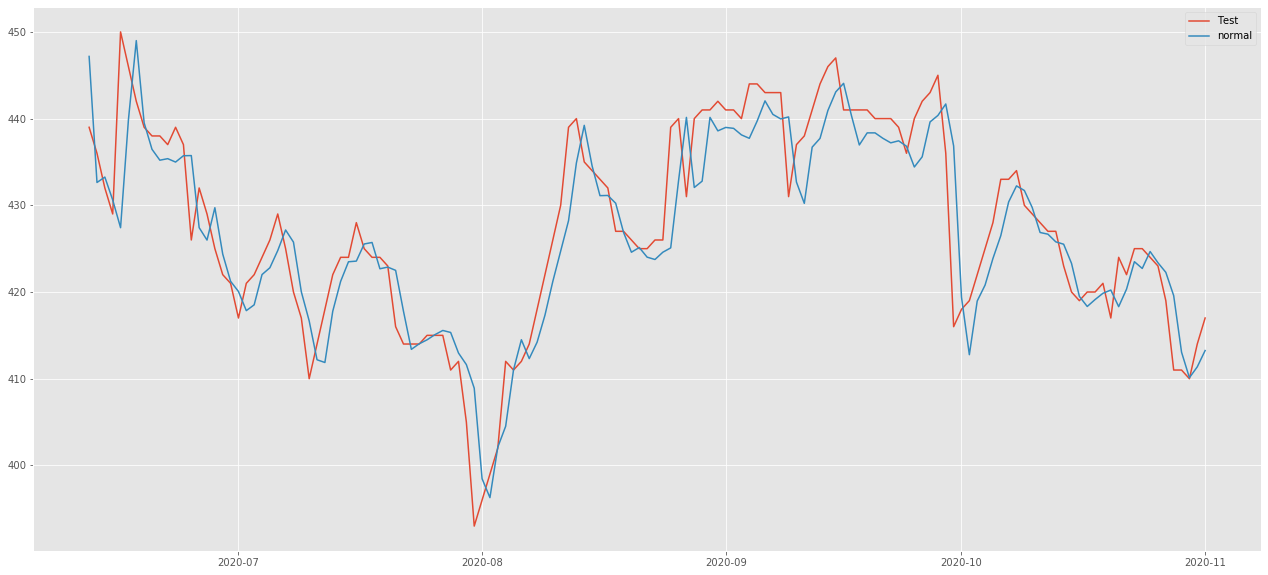

In [54]:
plt.figure(figsize=(22,10))
plt.plot(YN_test, label = 'Test')
plt.plot(gru_predict, label = 'normal')
plt.legend(loc='best')
#plt.savefig('画像/11-16/gru-epoch300.png')

# RMSE

In [55]:
rmse = np.sqrt(np.average(np.subtract(YN_test, lstm_predict) ** 2))
print('rmse:', rmse)

rmse: 4.765314276565368


In [56]:
rmse = np.sqrt(np.average(np.subtract(C_lstm_test, C_lstm_predict) ** 2))
print('rmse:', rmse)

rmse: 4.9800576262856815


In [57]:
rmse = np.sqrt(np.average(np.subtract(C_gru_test, C_gru_predict) ** 2))
print('rmse:', rmse)

rmse: 3.591812616707508


In [58]:
rmse = np.sqrt(np.average(np.subtract(YN_test, gru_predict) ** 2))
print('rmse:', rmse)

rmse: 5.021909177469935
